In [1]:
%matplotlib inline

In [2]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import backend as K
import numpy as np
import pandas as pd
from functools import reduce
from itertools import combinations
from keras.layers import Input
from keras.models import Model
from keras.utils import plot_model

Using TensorFlow backend.


In [3]:
def transformCards(cards):
    S = np.array([
        1*(cards[0] == cards[1]),
        1*(cards[2] == cards[1]),
        1*(cards[0] == cards[2])
    ])
    
    permut = np.array([
        S[0]*S[1]*S[2],
        np.bitwise_xor(S[0], np.bitwise_xor(S[1], S[2])),
        np.bitwise_xor(S[0]*S[1], np.bitwise_xor(S[1]*S[2], S[2]*S[0]))
    ])
    return permut
    
    T = np.zeros((12,3)).astype("int32")
    T[np.arange(12), cards.reshape(3*4)] = 1
    R = T.reshape(3,4,3)
    
    return R

In [4]:
def generateCard(): return np.random.randint(0,3,4).astype("int32")

In [5]:
def generateSet():
    A = generateCard()
    B = generateCard()
    return transformCards(np.array([A,B,(3-(A+B)%3)%3]).astype("int32"))

In [6]:
def isSet(cards):
    return (cards.sum(axis=0)%3).sum()==0

In [7]:
def generateNonSet():
    A = generateCard()
    B = generateCard()
    while True:
        C = generateCard()
        cards = np.array([A,B,C])
        if not isSet(cards):
            return transformCards(cards)

In [8]:
def generateDataset(N):
    X1 = np.array([generateSet() for _ in range(N)])
    X2 = np.array([generateNonSet() for _ in range(N)])
    Y = np.random.randint(0,2,N)
    shape = (1,)*(len(X1.shape)-1)
    Y1 = Y.reshape(N,*shape)
    return Y1*X1+(1-Y1)*X2, Y

In [30]:
Xtrain, Ytrain = generateDataset(3)

In [31]:
Xtest, Ytest = generateDataset(1000)

In [32]:
Xtrain.shape

(3, 3, 4)

In [33]:
def SetNet(inputLayer):
    X = [keras.layers.Lambda(lambda x: x[:, :, i])(inputLayer) for i in range(4)]
    #X = [keras.layers.Flatten()(c) for c in X]

    layer_1 = Dense(12, activation='relu')
    layer_2 = Dense(8, activation='relu')
    layer_3 = Dense(1, activation='sigmoid')
    
    X = [layer_1(c) for c in X]
    X = [layer_2(c) for c in X]
    X = [layer_3(c) for c in X]
    
    X = keras.layers.Multiply()(X)
    
    return X

In [34]:
inputLayer = Input(Xtrain[0].shape)
outputLayer = SetNet(inputLayer)

In [35]:
model = Model(inputs=inputLayer, outputs=outputLayer)

In [36]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [37]:
hist = model.fit(Xtrain, Ytrain,
          epochs=1000,
          verbose=0,
          validation_data=(Xtest, Ytest))

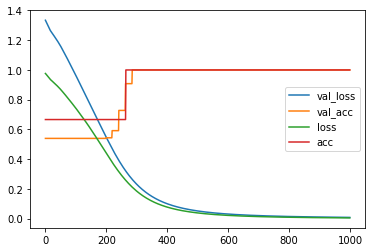

In [38]:
pd.DataFrame(hist.history).plot()

In [39]:
model.evaluate(Xtest, Ytest, verbose=0)

[0.008841807410120963, 1.0]

In [19]:
plot_model(model, show_shapes=True, to_file="file.png", show_layer_names=True)